# Wstęp do uczenia maszynowego - Projekt 2
## Aleksander Malinowski | Damian Skowroński

___

### Wprowadzenie
W projekcie przeprowadzimy klasteryzację na zbiorze [USCensus1990raw](https://archive.ics.uci.edu/ml/datasets/US+Census+Data+(1990)), w którym jest $1\%$ losowo wybranych obserwacji ze spisu ludności w USA z roku 1990. Celem jest pogrupowanie ludzi względem zarobków.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/census1990-mld/USCensus1990.data.txt')

In [ ]:
df.head()

,caseid,dAge,dAncstry1,dAncstry2,iAvail,iCitizen,iClass,dDepart,iDisabl1,iDisabl2,...,iTmpabsnt,dTravtime,iVietnam,dWeek89,iWork89,iWorklwk,iWWII,iYearsch,iYearwrk,dYrsserv
0,10000,5,0,1,0,0,5,3,2,2,...,0,5,0,2,1,1,0,11,1,0
1,10001,6,1,1,0,0,7,5,2,2,...,0,1,0,2,1,1,0,5,1,0
2,10002,3,1,2,0,0,7,4,2,2,...,0,2,0,2,1,1,0,10,1,0
3,10003,4,1,2,0,0,1,3,2,2,...,0,1,0,1,1,1,0,10,1,0
4,10004,7,1,1,0,0,0,0,2,2,...,3,0,0,0,2,2,0,5,6,0


We [wcześniej podanym linku](https://archive.ics.uci.edu/ml/datasets/US+Census+Data+(1990)) znajdują sie ważne informacje o zbiorze takie jak:

* z pierwotnego zbioru wybrano $68$ atrybutów, które zostały uznane za ważne
* atrybuty mają przedrostki składające się z jednej litery:
  * "i" - oryginalne wartości
  * "d" - wartości zostały jakoś zmapowane (zwykle po prostu sensownie pogrupowane)
  

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2458285 entries, 0 to 2458284
Data columns (total 69 columns):
 #   Column     Dtype
---  ------     -----
 0   caseid     int64
 1   dAge       int64
 2   dAncstry1  int64
 3   dAncstry2  int64
 4   iAvail     int64
 5   iCitizen   int64
 6   iClass     int64
 7   dDepart    int64
 8   iDisabl1   int64
 9   iDisabl2   int64
 10  iEnglish   int64
 11  iFeb55     int64
 12  iFertil    int64
 13  dHispanic  int64
 14  dHour89    int64
 15  dHours     int64
 16  iImmigr    int64
 17  dIncome1   int64
 18  dIncome2   int64
 19  dIncome3   int64
 20  dIncome4   int64
 21  dIncome5   int64
 22  dIncome6   int64
 23  dIncome7   int64
 24  dIncome8   int64
 25  dIndustry  int64
 26  iKorean    int64
 27  iLang1     int64
 28  iLooking   int64
 29  iMarital   int64
 30  iMay75880  int64
 31  iMeans     int64
 32  iMilitary  int64
 33  iMobility  int64
 34  iMobillim  int64
 35  dOccup     int64
 36  iOthrserv  int64
 37  iPerscare  int64
 38  dP

In [ ]:
df.isnull().sum().sum()

0

Widać, że wszystkie kolumny są liczbami całkowitymi i nie ma w nich braku danych przedstawionych jako *Null*. W opisie zbioru nie ma napisane, że pod jakimś znakiem kryją się brakujące wartości więc uznajemy, że takich nie ma.

W klasteryzacji nie będzie miała znaczenia zmienna *caseid* więc ją usuwamy.

In [ ]:
df.drop(columns = 'caseid', inplace = True)

Sprawdźmy jeszcze wielkość zbioru

In [ ]:
df.shape

(2458285, 68)

Zbiór jest bardzo duży, więc mogą wystąpić problemy z niektórymi metodami klasteryzacji

## Preprocessing 

Sprawdźmy rozkłady zmiennych.

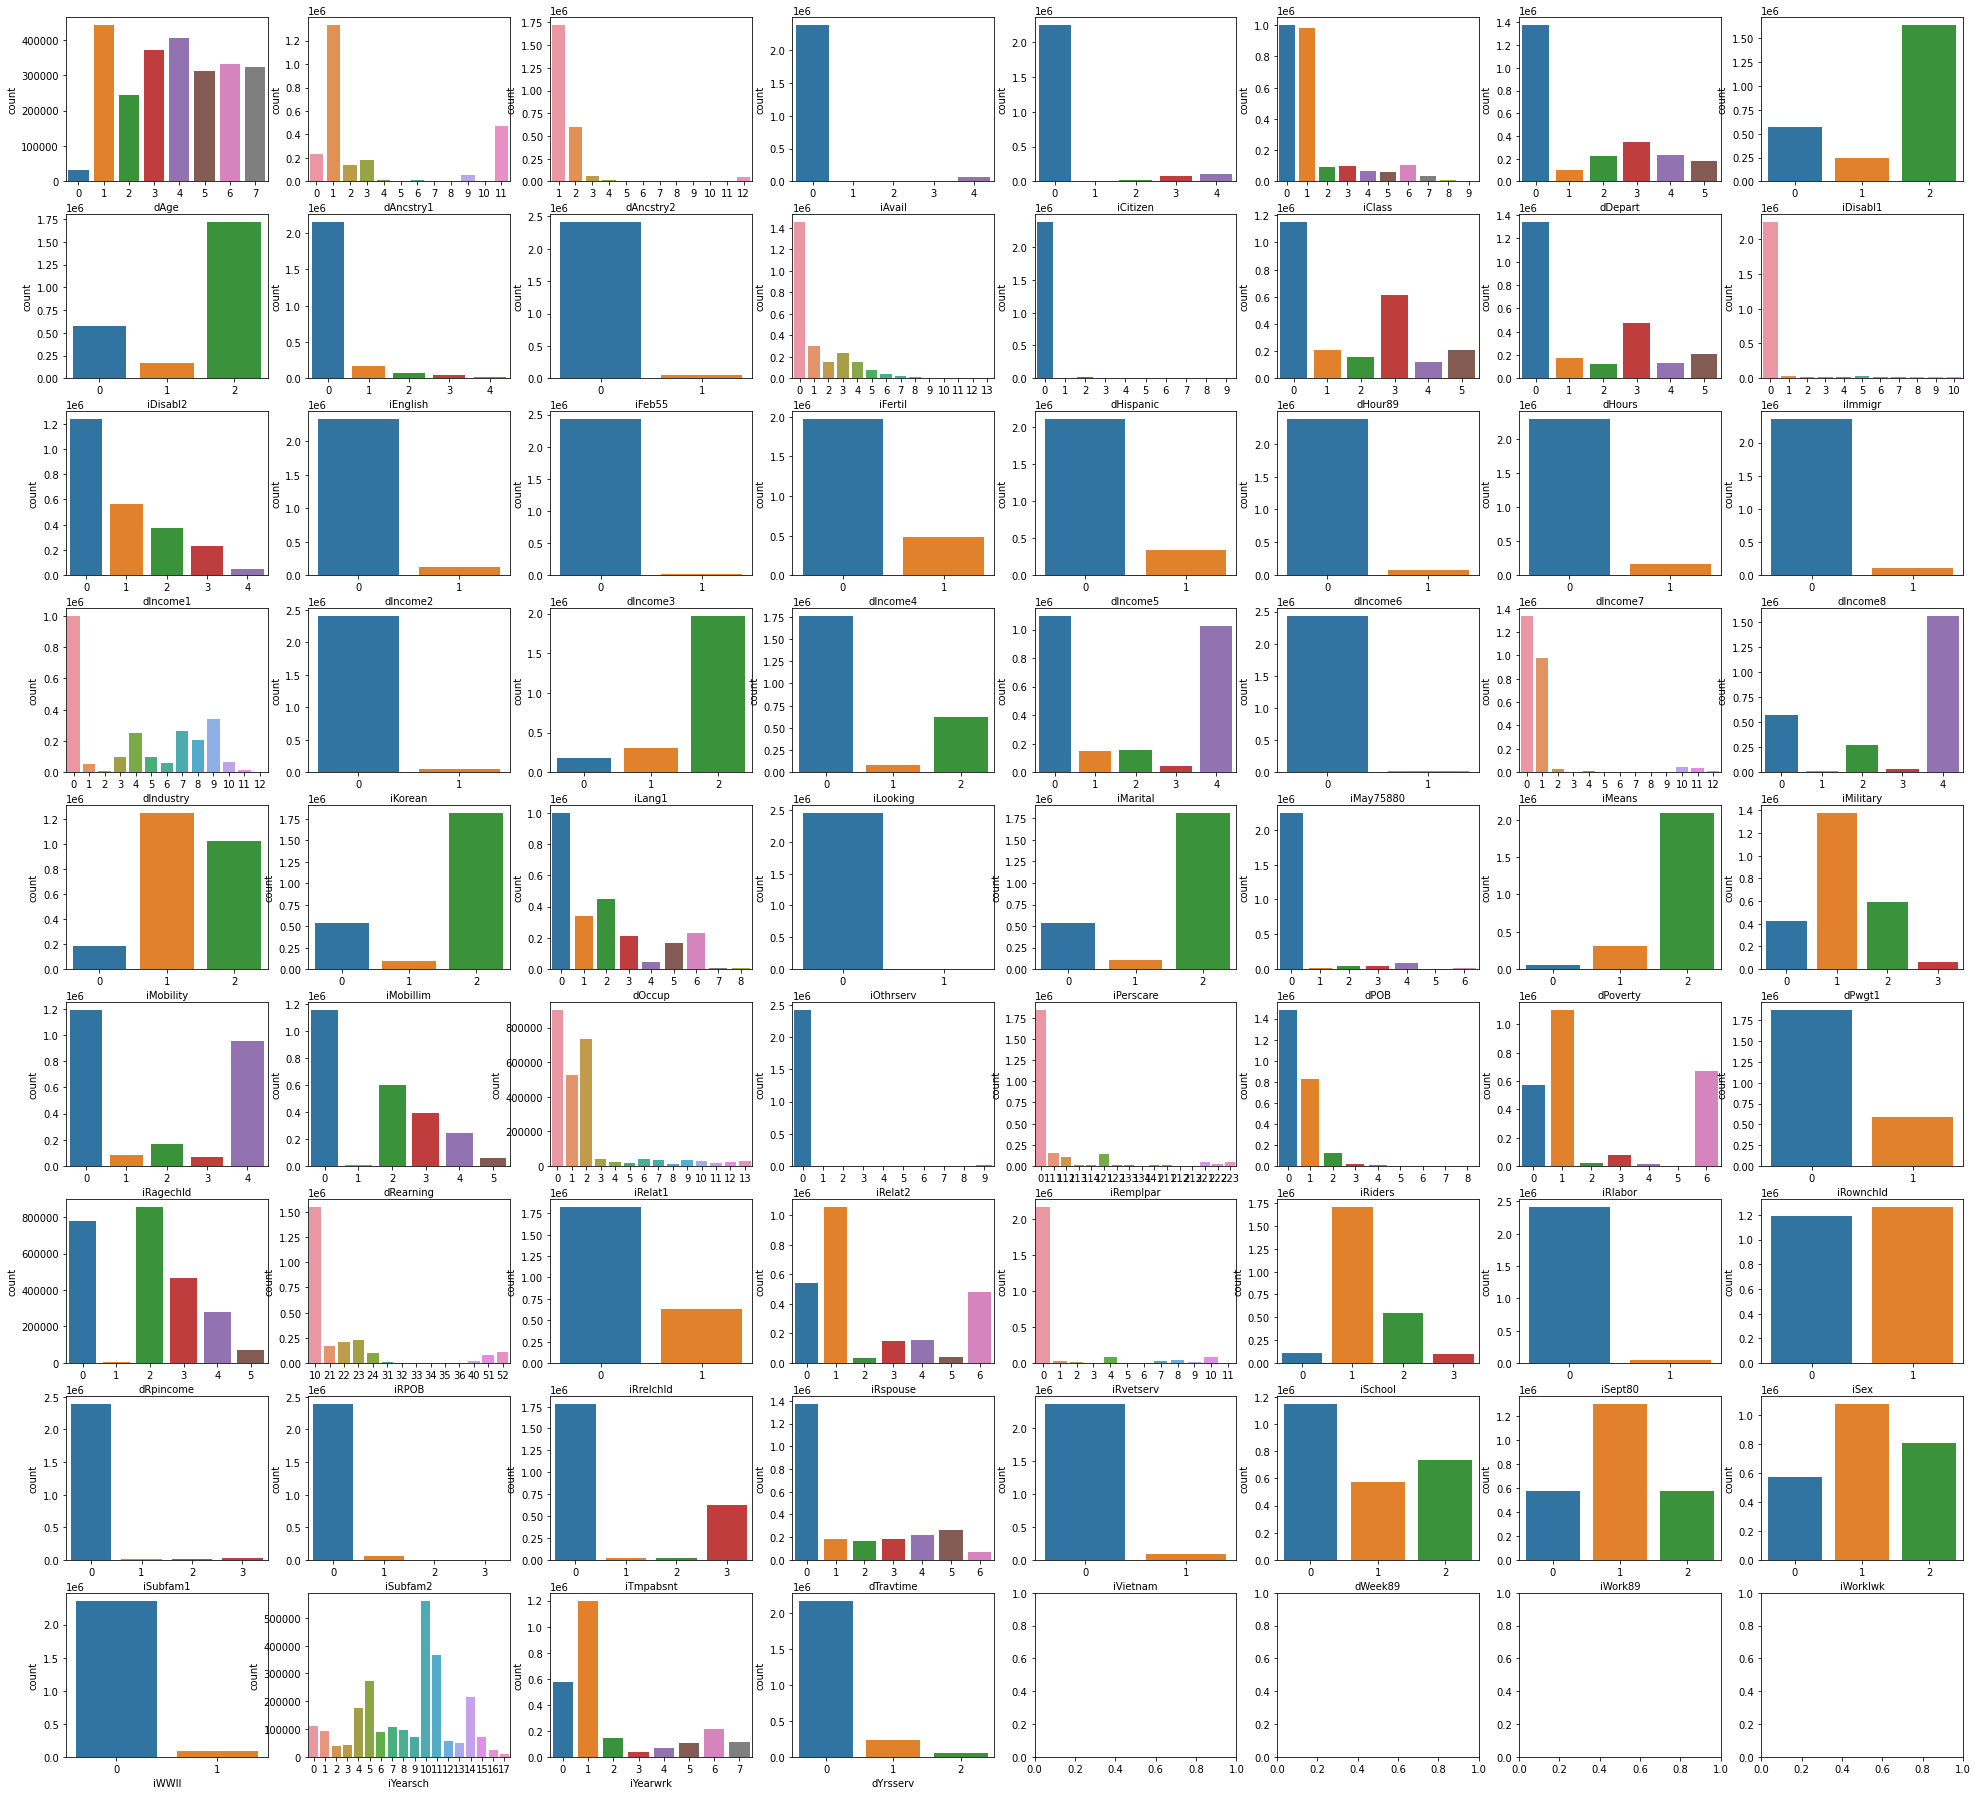

In [ ]:
fig, ax = plt.subplots(9, 8, figsize = (34,32))


col = 0

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
      if col > len(df.columns)-1:
        break
      sns.countplot(df.iloc[:,col], ax=ax[i,j])      
      col += 1

Z opisu zmiennych dla tego zbioru możemy dowiedzieć się, że jest wiele kolumn dotyczących służenia w wojsku, są to:

* *iFeb55* - służył w wojsku w lutym 1955 roku 
* *iKorean* - służył wojny z Koreą
* *iMay75880* - służył w wojsku w maju 1988 roku  
* *iMilitary* - służył w wojsku ogólnie
* *iOtherserv* - czy służył w wojsku kiedy indziej
* *iSept80* - czy służył w wojsku w październiku 1980 roku
* *iVietnam* - czy służył podczas wojny z Witnamem
* *iRvetserv* - różne stopnie bycia weteranem
* *iWWII* - czy służył podczas drugiej wojny światowej

Wystarczy nam chyba po prostu wiedza, czy ktoś służył w wojsku, więc zobaczymy, czy zmienna *iMilitary* będzie mogła nam to opisać.

Zmienna *iRspouce* zawiera się w zmiennej *iMarital* więc po prostu usuniemy pierwszą z nich.

In [ ]:
df.drop(columns = 'iRspouse', inplace = True)

Wykonamy klasteryzację, aby pogrupować ludzi względem zarobków wobec tego usuwamy zmienną dokładnie opisującą to.

In [ ]:
df.drop(columns = 'dIncome1', inplace = True)

Sprawdzimy, czy dane z kolumn mających związek z wojskiem pokrywają się z kolumną **iMilitary**

In [ ]:
def check_military():
  df_mil = df[['iRvetserv','iFeb55', 'iKorean','iMay75880','iMilitary','iOthrserv','iSept80','iVietnam','iWWII']]
  df_mil_mil = df_mil.loc[(df_mil['iMilitary'] == 1) | (df_mil['iMilitary'] == 2) | (df_mil['iMilitary'] == 3)]
  df_without_mil = df_mil_mil.drop(columns=['iMilitary'])
  x=df_without_mil.loc[(df_without_mil==0).all(axis=1)]
  print('Liczba obserwacji w których w kolumnie iMilitary jest, że byli w wojsku, a żadnej innej kolumnie nie jest to zaznaczone =', x.shape[0])
  df_no_mil = df_mil.loc[(df_mil['iMilitary'] == 0) | (df_mil['iMilitary'] == 4)]
  df_without_mil = df_no_mil.drop(columns=['iMilitary'])
  x=df_without_mil.loc[(df_without_mil!=0).any(axis=1)]
  print('Liczba obserwacji w których w kolumnie iMilitary jest, że byli w nie byli w wojsku, a w którejś z kolumn jest, że byli =', x.shape[0])
check_military()

Liczba obserwacji w których w kolumnie iMilitary jest, że byli w wojsku, a żadnej innej kolumnie nie jest to zaznaczone = 31466
Liczba obserwacji w których w kolumnie iMilitary jest, że byli w nie byli w wojsku, a w którejś z kolumn jest, że byli = 0


Na szczęście okazuję się, że nie ma takich niespójności miedzy tymi kolumnami. Dodatkowo dowiadujemy się, że w kolumnie **iMilitary** jest po prostu zawarte więcej informacji. Wobec tego wyrzucimy wojskowe kolumny oprócz niej.

In [ ]:
df.drop(columns = ['iRvetserv','iFeb55', 'iKorean','iMay75880','iOthrserv','iSept80','iVietnam','iWWII'], inplace = True)

Z pairplota nie dowiadujemy się na ten moment niczego:

<Figure size 432x288 with 0 Axes>

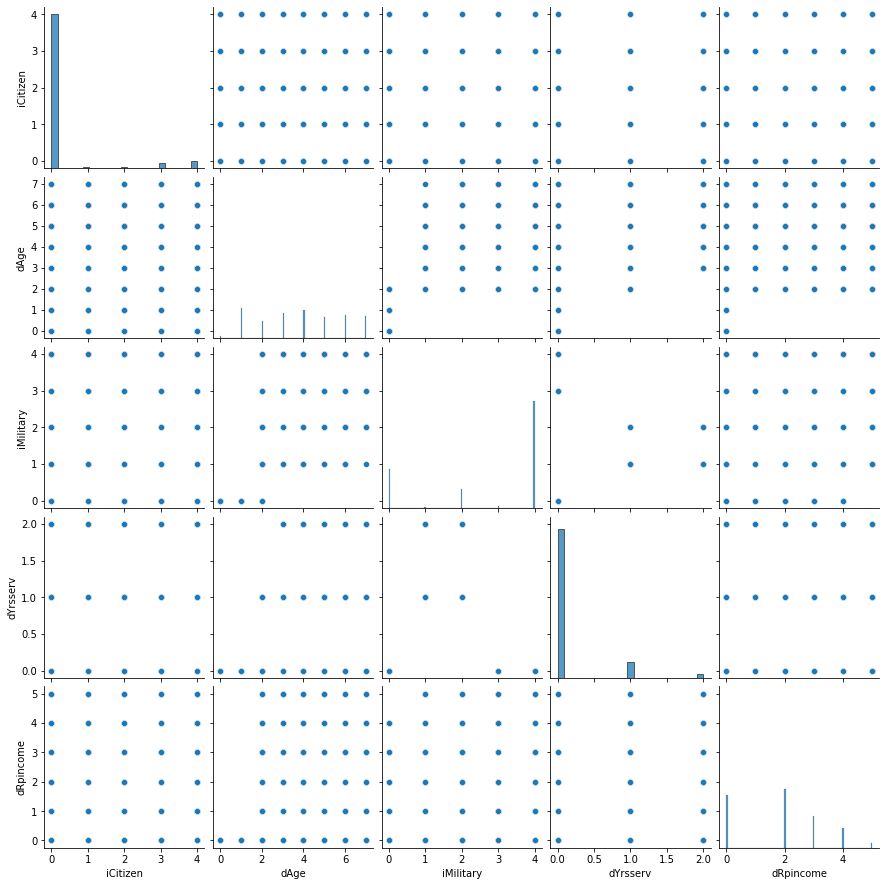

In [ ]:
cols_to_plot = ["iCitizen", "dAge", "iMilitary", "dYrsserv","dRpincome"]
plt.figure()
sns.pairplot(df[cols_to_plot])
plt.show()

Sprawdzimy korelacje Spearmana, a następnie usuniemy zmienne o dużej korelacji.

In [ ]:
cm = df.corr('spearman')

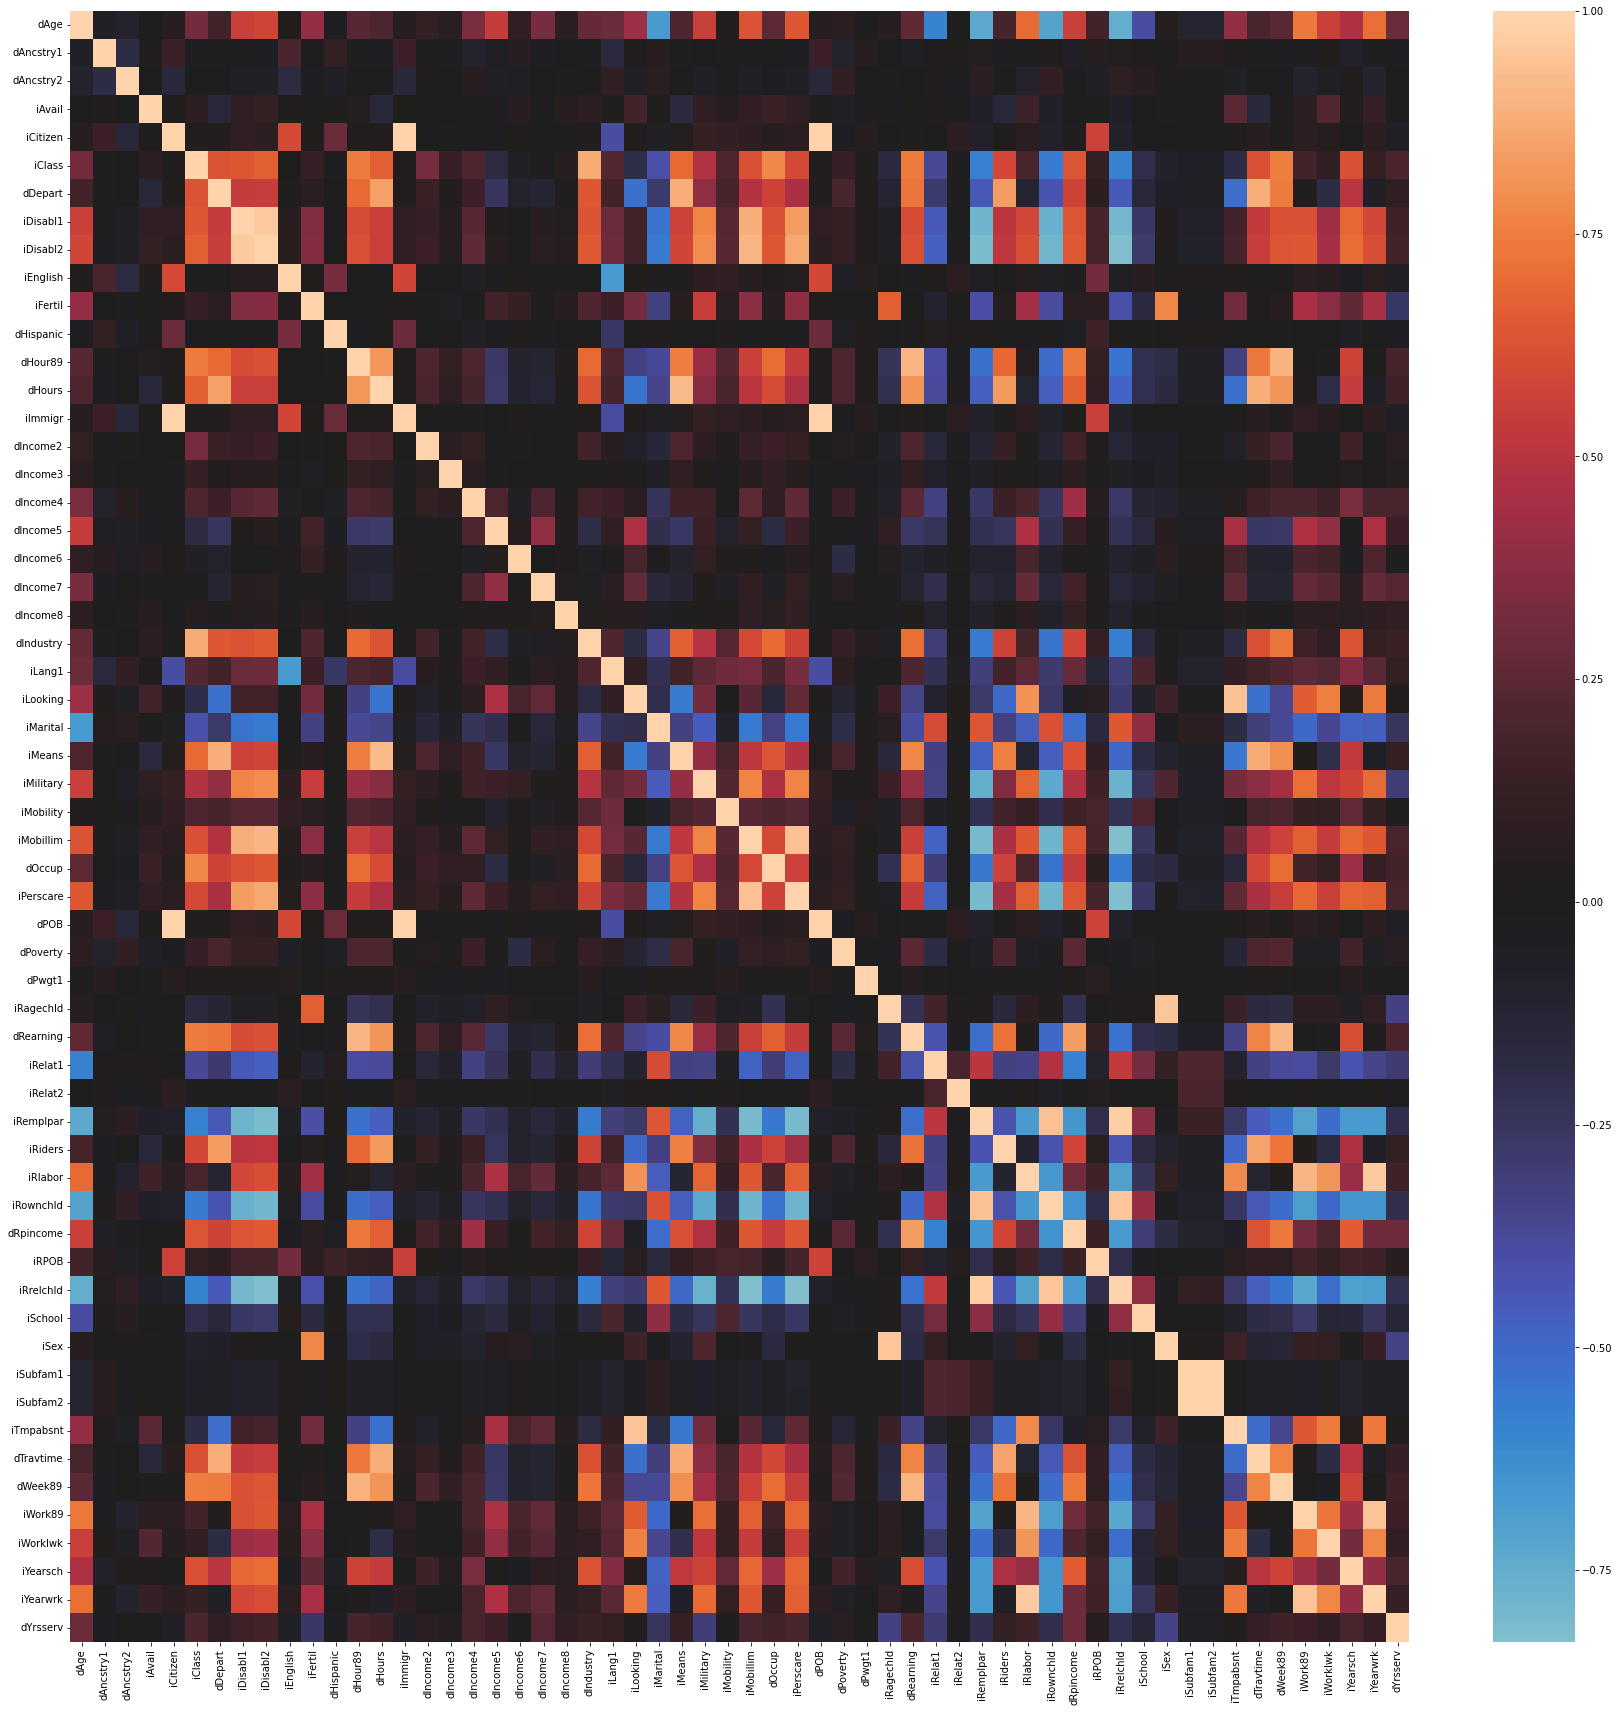

In [ ]:
plt.figure(figsize=(30,30))  
sns.heatmap(cm, center=0, annot=False)

Z wykresu widać, że są takie zmienne, które mają ze sobą wysoką korelację, więc z nich będziemy usuwać jedną z nich, dla modułu korelacji większego niż 0.8. 

In [ ]:
def columnsToRemove(data,limit,cm):
    ctr = []
    n = data.shape[1]
    for i in range(n):
        for j in range(i,n):
            corr_AB = cm.iloc[i,j]
            sum_A_corrs = np.abs(cm.iloc[:,i]).sum()
            sum_B_corrs = np.abs(cm.iloc[:,j]).sum()
            if abs(corr_AB) > limit and i != j and data.columns[i] not in ctr and data.columns[j] not in ctr:
              if sum_A_corrs > sum_B_corrs and data.columns[i] not in ctr and data.columns[i]!='iMilitary' and data.columns[i]!='iMarital': # wyrzucamy kolumnę, która jest bardziej skorelowana z resztą
                ctr.append(data.columns[i])
              elif data.columns[j] not in ctr and data.columns[j]!='iMilitary' and data.columns[j]!='iMarital': 
                ctr.append(data.columns[j])
    return ctr
ver2 = columnsToRemove(df,0.8,cm)
ver2

['iImmigr',
 'iCitizen',
 'iClass',
 'dHours',
 'iMeans',
 'dDepart',
 'iDisabl2',
 'iMobillim',
 'iPerscare',
 'iRrelchld',
 'dRearning',
 'dWeek89',
 'iRlabor',
 'iLooking',
 'iRagechld',
 'iRemplpar',
 'dTravtime',
 'iSubfam1',
 'iYearwrk']

Wychodzi, że takich kolumn do usunięcia jest 19.



In [ ]:
df.drop(ver2, axis='columns', inplace=True)

Korelacja po usunięciu kolumn:

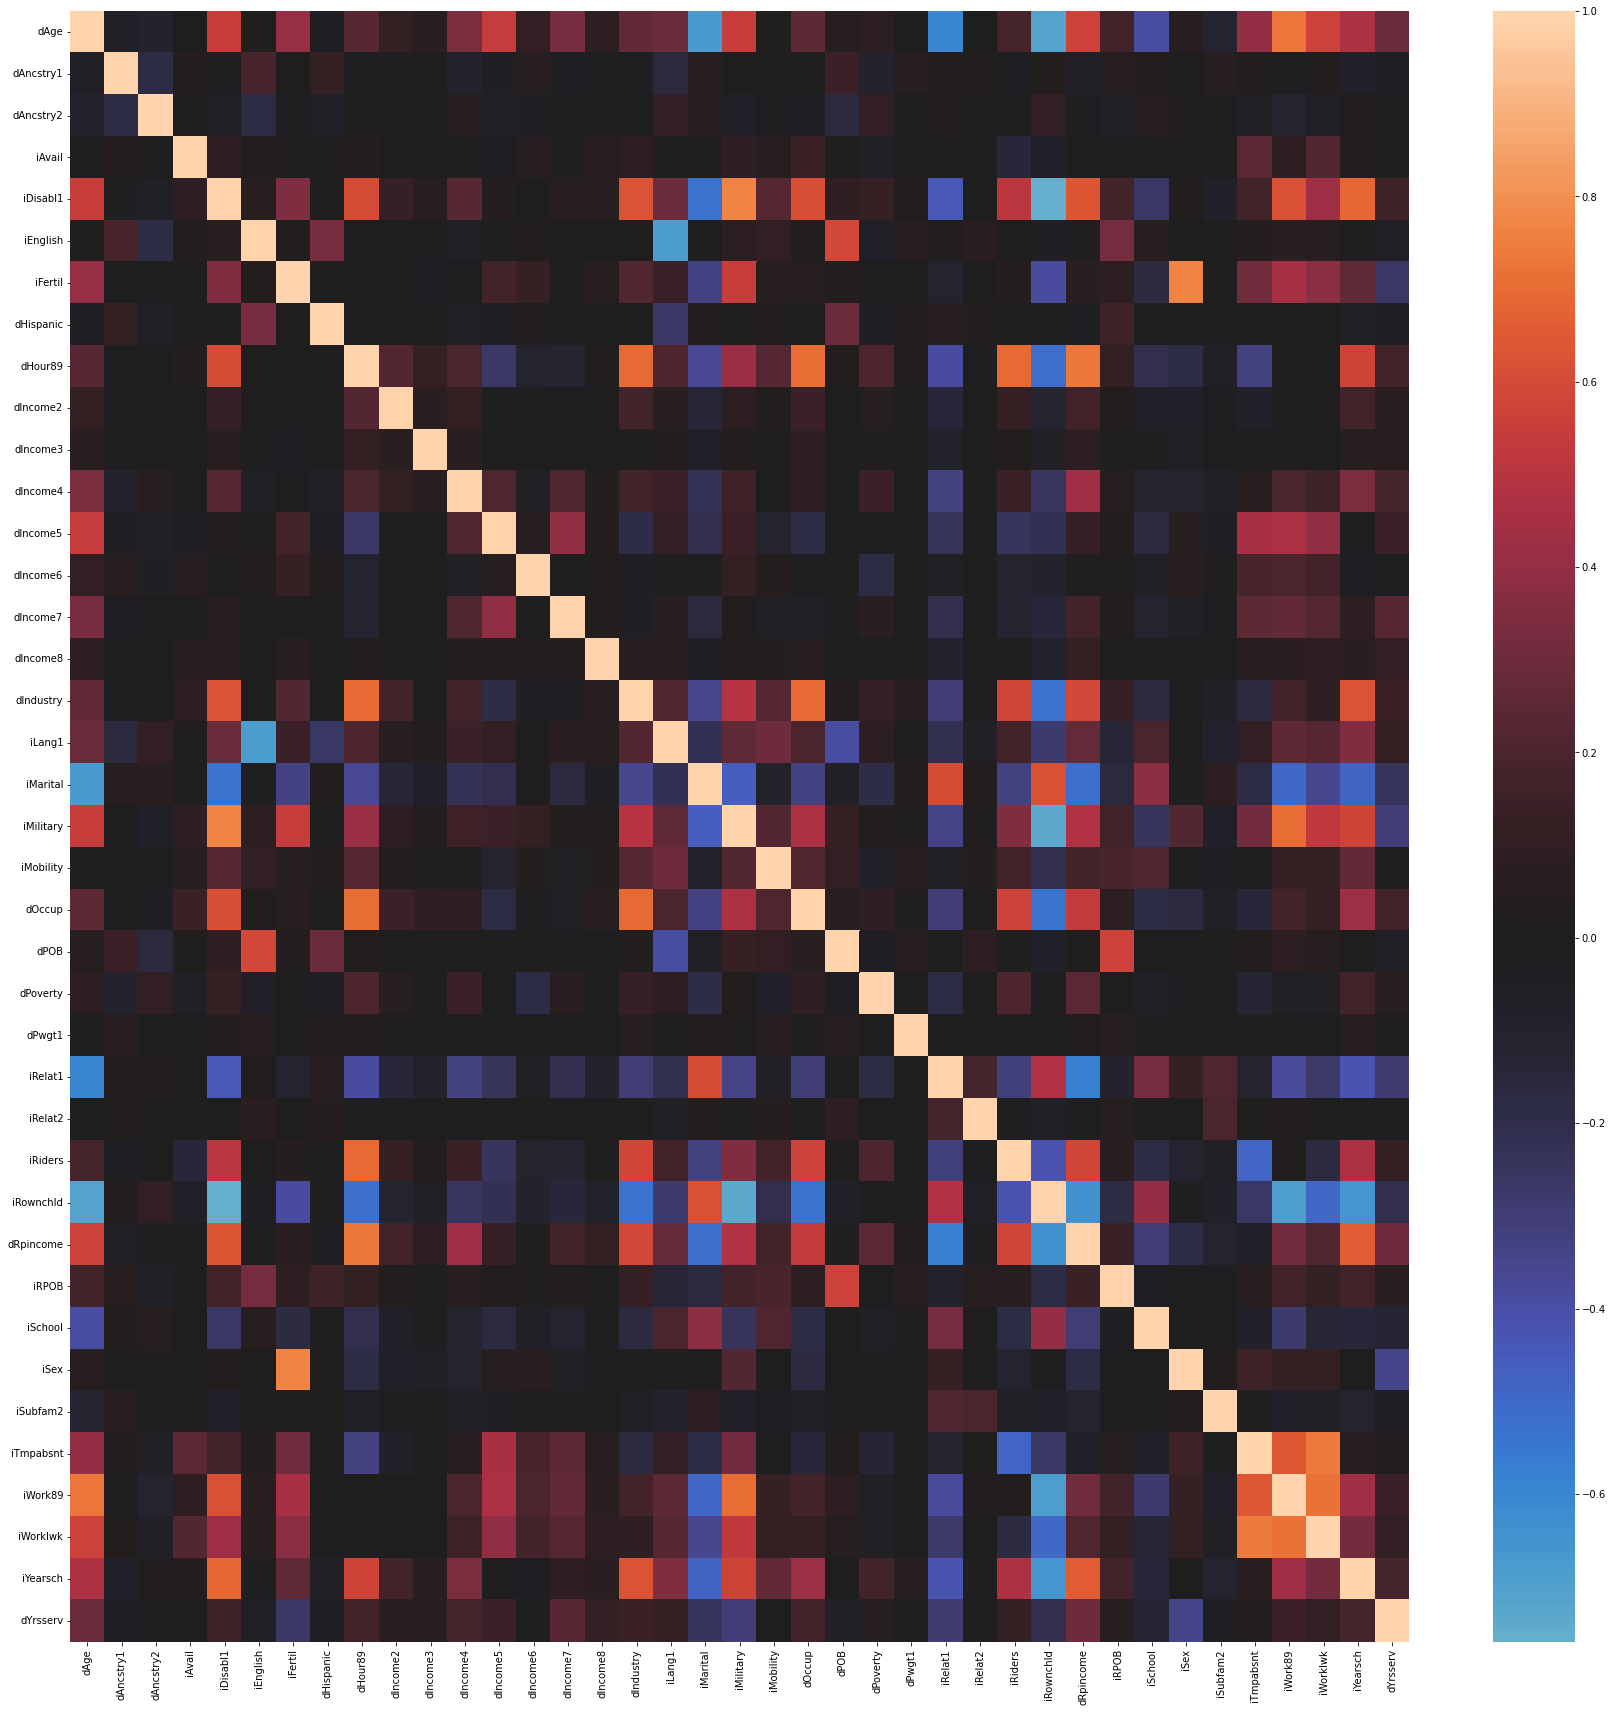

In [ ]:
cm = df.corr('spearman')
plt.figure(figsize=(30,30))  
sns.heatmap(cm, center=0, annot=False)

Nadal jest kilka miejsc, w których korelacja jest całkiem duża, ale nie jest to więcej niż 0.8.

In [ ]:
df.shape

(2458285, 39)

Ostatecznie nasz zbiór ma 39 zmiennych. 

## Clustering 
Po skończonym preprocessingu przechodzimy do clusteringu. Wybróbujemy dwa sposoby:

1. Wykonując PCA
2. Bez wykonywania PCA

Taki podział stosujemy, ponieważ wszystkie nasze zmienne są kolumnami o wartościach całkowitych i niekoniecznie uporządkowanych jakoś hierarchincznie.

### Clustering z użyciem PCA
Przed przeprowadzeniem PCA wykonamy labeling niektórych zmiennych, które nie mają konkretnej kolejności po wadze, w sensie że ich wyników nie można porównać.
Przykładowo w zmiennej **dHispanic** jest określona informacja z jakiego hiszpańsko języcznego państwa pochodzi. Dla takich zmiennych zastosujemy mapping zgodnie z częstością pojawienia.

In [ ]:
def labelByOrder(df,columns):
  # funkcja na danym df zmapuje kolumny columns w zalenożności od czestosci pojawiania się wartości, zwraca dictionary z wykonanymi mapowaniami  
  mappings = {}
  for col in columns:
    values = list(df[col].value_counts().index)
    ordered = np.arange(len(values))
    d = {k:v for k,v in zip(values,ordered)}
    df.replace({col:d}, inplace = True)
    mappings[col] = d
  return mappings

columns = ['iAvail','iDisabl1','dHispanic','dIndustry','iMarital','iMilitary','iMobility','dOccup','dPOB','dPoverty','iRelat1','iRelat2','iRPOB','iSchool','iTmpabsnt']
df_labeled = df.copy(deep = True)
mappings = labelByOrder(df_labeled,columns) # mappings przyda się kiedy będziemy odwracać, żeby odczytać wartości

Na zmapowanej ramce danych wykonujemy skalowanie i PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [ ]:
scaler = StandardScaler()
scaler.fit(df_labeled)
scaled_df = pd.DataFrame(scaler.transform(df_labeled),columns= df_labeled.columns)

,dAge,dAncstry1,dAncstry2,iAvail,iDisabl1,iEnglish,iFertil,dHispanic,dHour89,dIncome2,...,iRPOB,iSchool,iSex,iSubfam2,iTmpabsnt,iWork89,iWorklwk,iYearsch,dYrsserv,Clusters
count,2.458285e+06,2.458285e+06,2.458285e+06,2.458285e+06,2.458285e+06,2.458285e+06,2.458285e+06,2.458285e+06,2.458285e+06,2.458285e+06,...,2.458285e+06,2.458285e+06,2.458285e+06,2.458285e+06,2.458285e+06,2.458285e+06,2.458285e+06,2.458285e+06,2.458285e+06,2.458285e+06
mean,8.902695e-15,3.359642e-15,1.707195e-14,2.160516e-14,1.527685e-14,4.786933e-15,-8.707750e-16,-1.459564e-14,1.469999e-14,2.284564e-14,...,-5.780851e-15,9.419826e-15,-1.076733e-14,-1.426610e-14,6.899789e-15,3.458941e-15,-2.585666e-15,-1.068080e-15,7.607119e-15,-2.170026e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.880234e+00,-8.163476e-01,-3.385623e-01,-1.628802e-01,-6.504084e-01,-3.249300e-01,-6.347876e-01,-1.530028e-01,-9.142494e-01,-2.282855e-01,...,-6.102757e-01,-5.665787e-01,-1.031024e+00,-1.610462e-01,-5.650285e-01,-1.462637e+00,-1.472413e+00,-2.069938e+00,-3.449280e-01,-2.349409e+00
25%,-9.039057e-01,-5.688950e-01,-3.385623e-01,-1.628802e-01,-6.504084e-01,-3.249300e-01,-6.347876e-01,-1.530028e-01,-9.142494e-01,-2.282855e-01,...,-6.102757e-01,-5.665787e-01,-1.031024e+00,-1.610462e-01,-5.650285e-01,-1.048797e-03,-1.278010e-01,-8.446219e-01,-3.449280e-01,-6.116214e-01
50%,7.242261e-02,-5.688950e-01,-3.385623e-01,-1.628802e-01,-6.504084e-01,-3.249300e-01,-6.347876e-01,-1.530028e-01,-3.355877e-01,-2.282855e-01,...,-6.102757e-01,-5.665787e-01,9.699097e-01,-1.610462e-01,-5.650285e-01,-1.048797e-03,-1.278010e-01,3.806946e-01,-3.449280e-01,2.572723e-01
75%,1.048751e+00,-7.398991e-02,2.510083e-01,-1.628802e-01,8.456380e-01,-3.249300e-01,4.397253e-01,-1.530028e-01,8.217357e-01,-2.282855e-01,...,4.965065e-01,7.671414e-01,9.699097e-01,-1.610462e-01,1.301828e+00,-1.048797e-03,1.216811e+00,6.257579e-01,-3.449280e-01,1.126166e+00
max,1.536915e+00,1.905631e+00,6.146715e+00,1.593546e+01,2.341684e+00,5.838636e+00,6.349546e+00,1.328956e+01,1.979059e+00,4.380479e+00,...,6.583808e+00,3.434581e+00,9.699097e-01,1.752769e+01,5.035542e+00,1.460540e+00,1.216811e+00,2.096138e+00,4.611228e+00,1.995060e+00


Text(0, 0.5, 'cumulative explained variance')

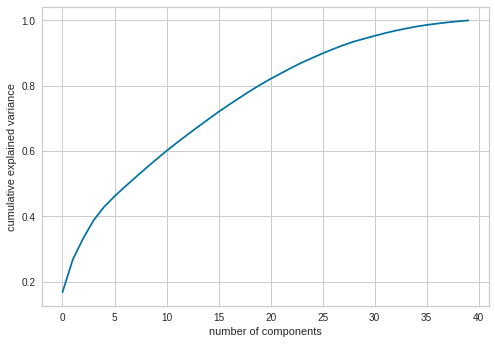

In [ ]:
pca = PCA().fit(scaled_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Wychodzi na to, że potrzeba około 30 komponentów, aby otrzymać wariancję ~0.95, wobec tego użycie PCA mija się z celem. Nie mam sensu używać go tylko po to, żeby pozbyć się ~10 zmiennych.

In [ ]:
pca = PCA(n_components = 0.95)
pca.fit(scaled_df)
PCA_df_variance = pd.DataFrame(pca.transform(scaled_df))

In [ ]:
PCA_df_variance

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,-2.230821,-2.271372,1.801611,0.020654,-0.759761,1.444434,-1.006718,0.742702,1.767693,1.056726,...,-1.228513,-0.378376,0.768335,1.131365,-0.675007,-0.287547,-0.683501,1.693398,-0.670767,0.869955
1,-1.210594,1.144452,0.807315,-1.482404,0.497850,0.832455,-1.823450,-0.705054,0.060671,0.182368,...,0.630746,-0.554312,1.466096,0.273986,-0.868645,0.161925,1.686687,-0.358631,-0.124982,0.589564
2,-1.941683,-2.562750,0.399758,-1.343284,1.434527,-1.368896,-0.506514,-0.450317,5.494699,-4.276583,...,0.837535,-0.161793,0.017835,-0.784422,0.157877,-0.517363,-0.124798,-0.305052,-0.547703,-0.248797
3,-1.119754,-0.323991,0.302893,-1.813757,-0.287642,0.617584,-0.983665,0.679064,0.724727,2.824434,...,-0.118460,-0.429695,0.402016,-0.440236,0.611548,-0.321477,0.067884,-0.139222,-0.404291,0.018152
4,-1.790948,3.395382,-0.283205,-0.556828,-1.179008,-0.389431,0.671412,-0.382179,-0.413382,-0.717605,...,-0.295666,0.417957,-0.513924,-0.529585,0.242451,1.123669,1.195461,-0.564652,0.043193,0.989998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458280,-2.158692,2.366032,-4.069894,2.534237,-1.008027,-0.249475,1.152388,-0.489423,-0.581914,-0.910161,...,1.689549,-0.710685,0.968778,-0.867625,0.824968,0.376822,0.433036,-0.251943,0.056703,0.642668
2458281,4.161892,-0.219460,-0.715021,-0.905458,-0.704888,-0.073494,-0.161031,0.471207,-0.465479,0.421380,...,0.174558,0.098601,-0.245362,0.043659,0.041673,-0.365556,0.175366,0.097189,-0.380927,0.274874
2458282,-1.287452,-2.928792,1.239255,0.459631,0.669114,-0.484753,-0.055451,-0.553481,0.636409,0.628987,...,-0.434983,-0.556098,-0.186648,0.506604,-0.169899,-0.159096,0.014362,-0.486789,-0.577704,-0.384772
2458283,-0.998992,-0.343162,2.192550,1.007260,-1.397198,-0.770922,-0.340450,0.167023,0.664753,0.365291,...,2.303560,1.815017,-1.725948,0.504281,0.593127,-0.128735,0.844250,-0.699109,-0.869234,-0.392871


### Clustering bez PCA
Ponieważ nie używamy PCA nie będziemy też skalować wartości. Użyjemy ich tak jak są.

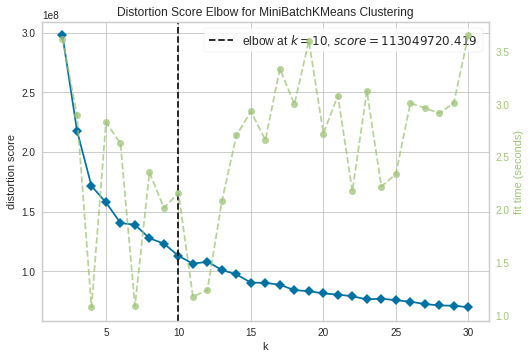

In [ ]:
from sklearn.cluster import MiniBatchKMeans
Elbow_M = KElbowVisualizer(MiniBatchKMeans(), k=30)
Elbow_M.fit(df)
Elbow_M.show()

Co prawda KElbowVisualiser wyświetla, że odpowienią liczbą klastrów jest 10 jednak według nas już dla 6 nie ma bardzo znaczącej różnicy, oprócz tego wybór 6 jest dla nas wygodniejszy by łatwiej będzie podzielić i opisać ludzi w 6 klastrach niż w 10. 

Wykonujemy klasteryzjację używając MiniBatchKMeans

In [ ]:
MBKM = MiniBatchKMeans(n_clusters=6)
pred = MBKM.fit_predict(df)
df["Clusters"] = pred

Sprawdźmy rozkład klastrów

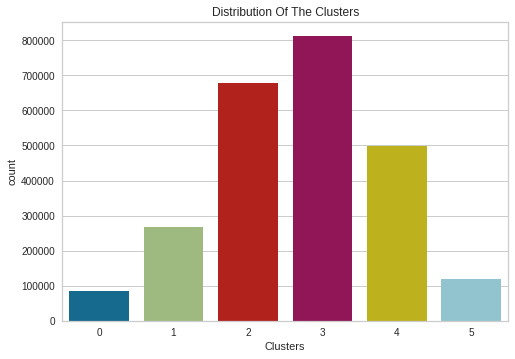

In [ ]:
pl = sns.countplot(x=df["Clusters"])
pl.set_title("Distribution Of The Clusters")
plt.show()

Wyszło na to, że są duże róznice pomiędzy licznością klastrów, co wydaje się dobre dla naszego celu, ponieważ na przyklad klastry z przecietnymi zarobkami powinny mieć bardzo dużą liczbność natomiast, te z najwyższymi - najmniejszą. 

Zobaczymy teraz jakie są różnice w rozkładach i spróbujemy z tego oddzielić konkretne grupy.

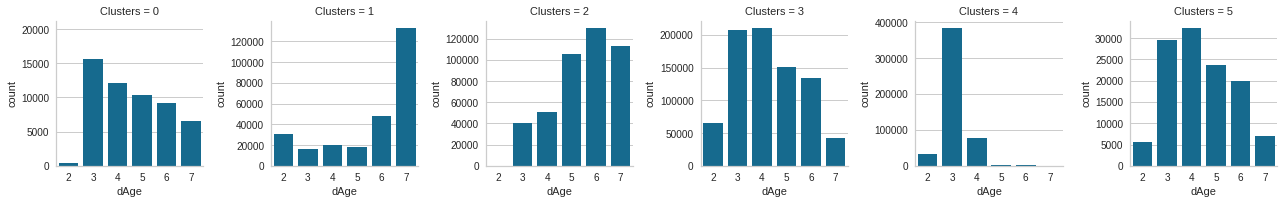

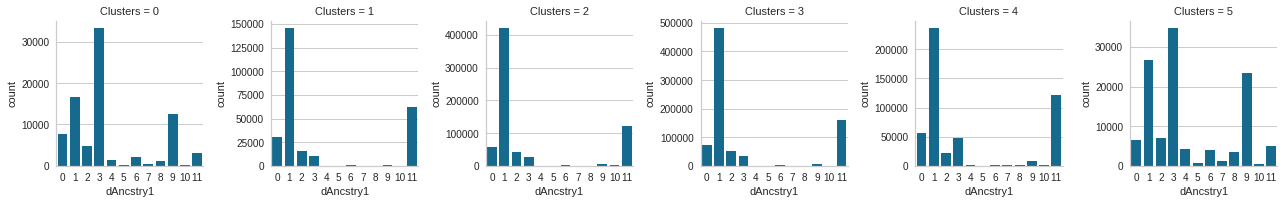

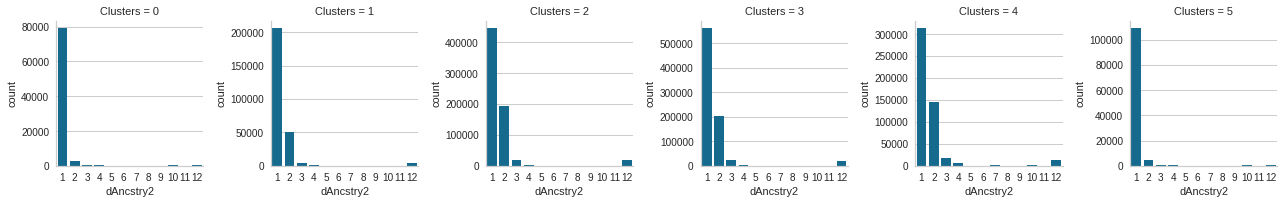

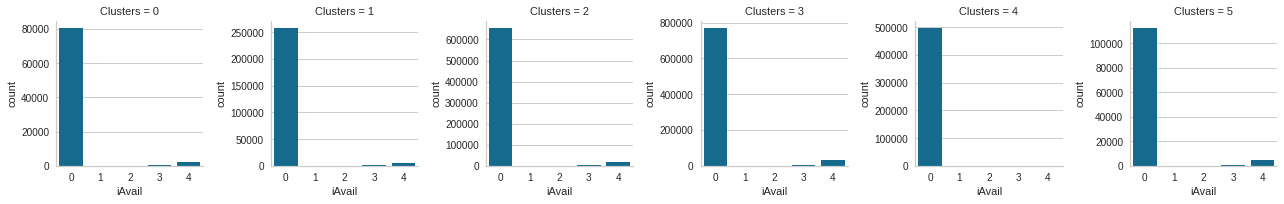

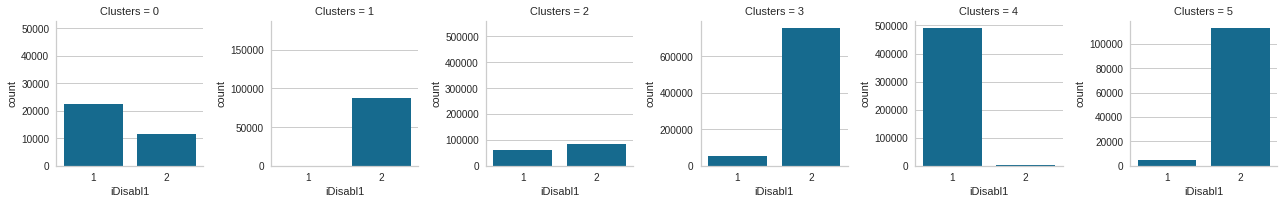

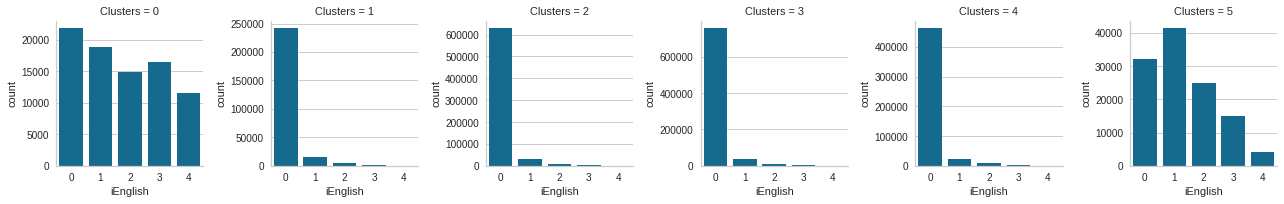

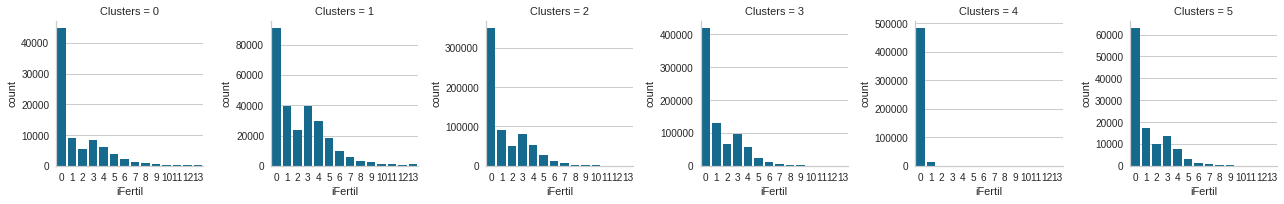

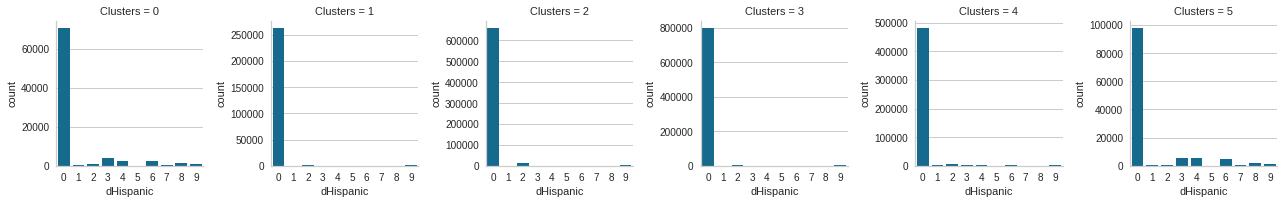

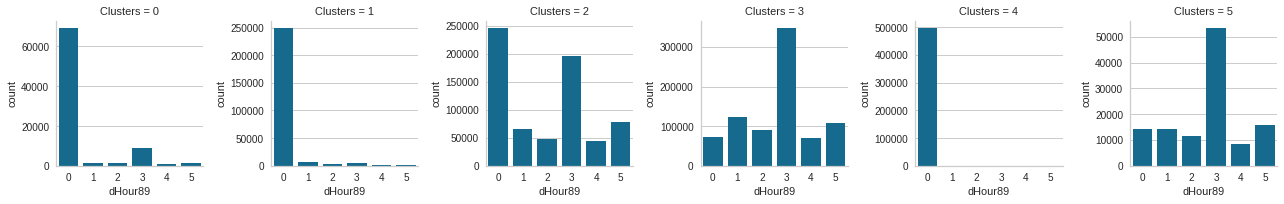

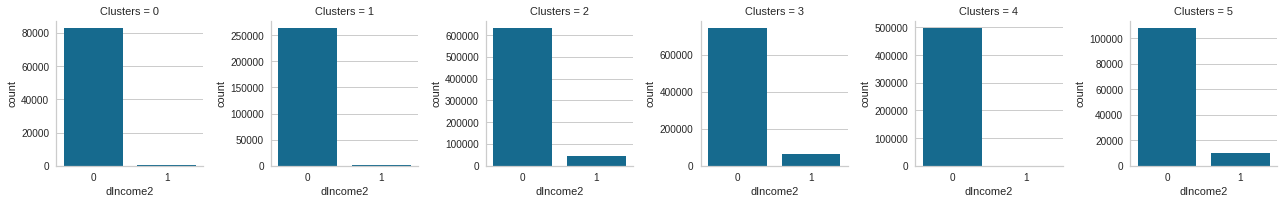

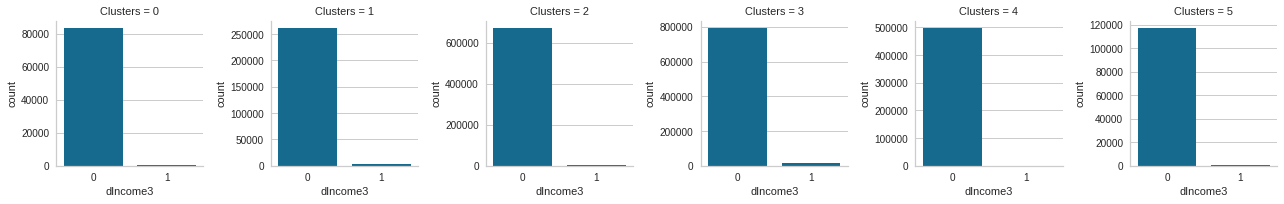

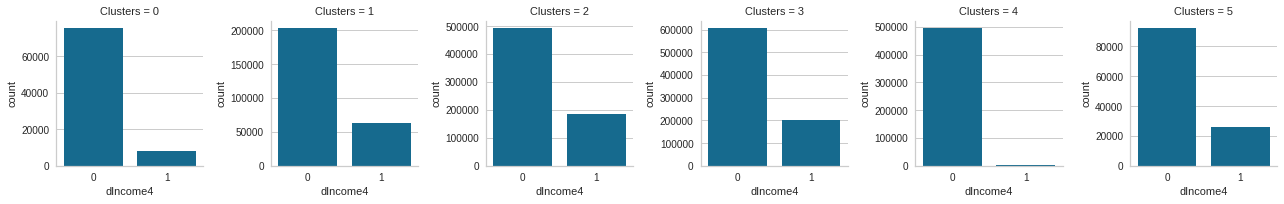

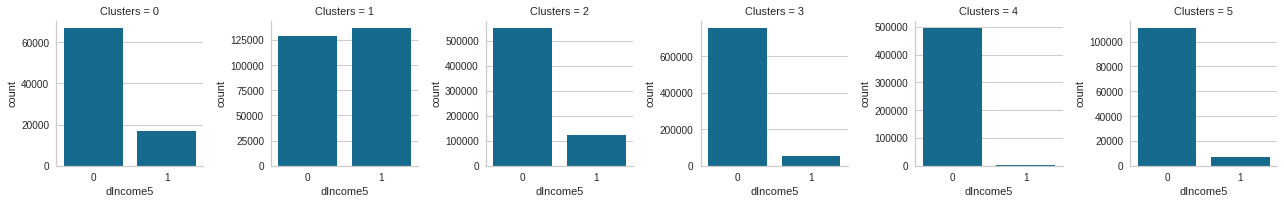

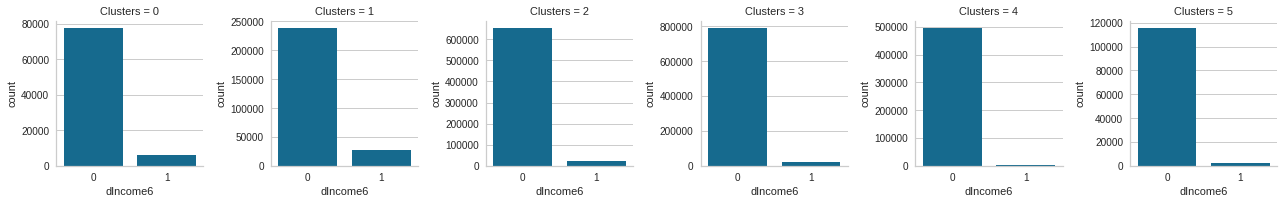

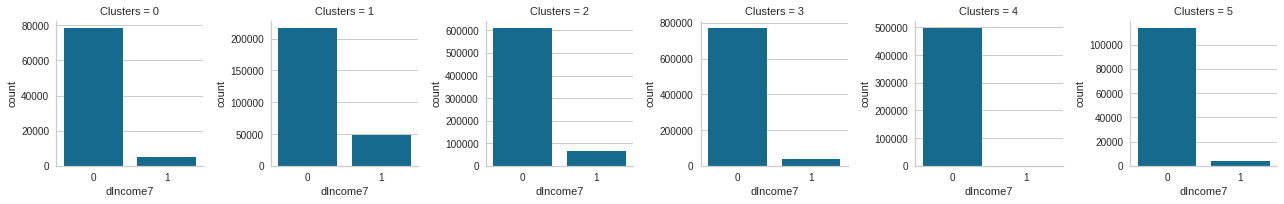

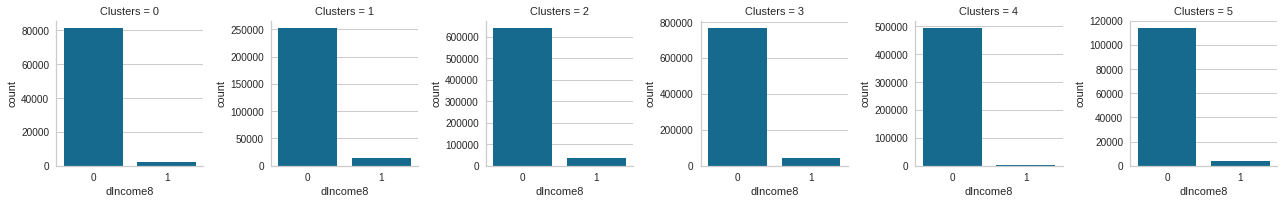

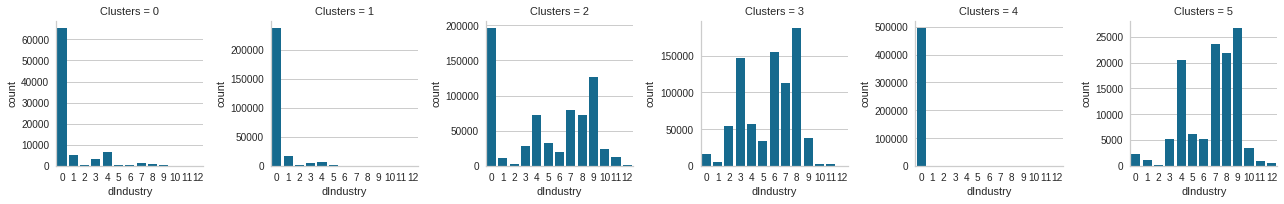

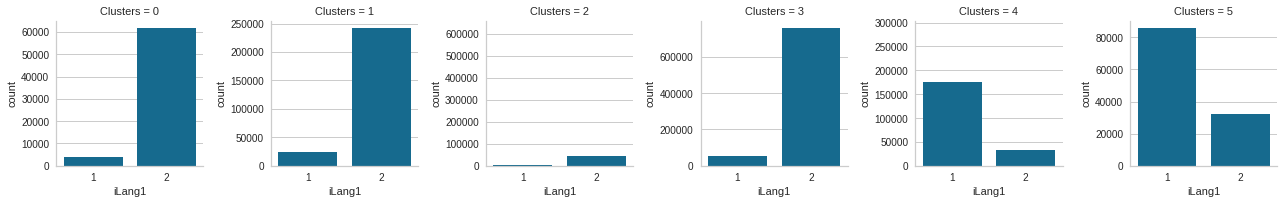

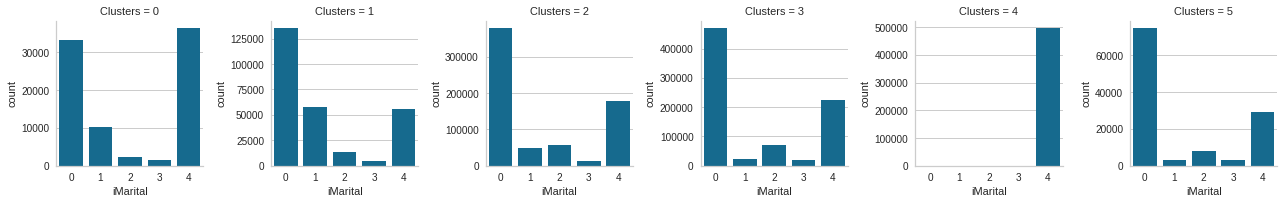

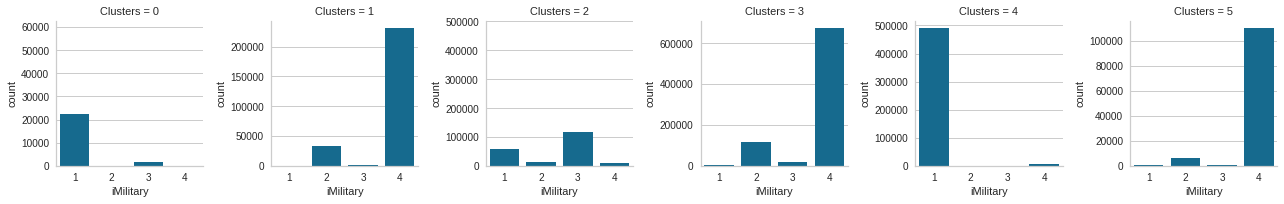

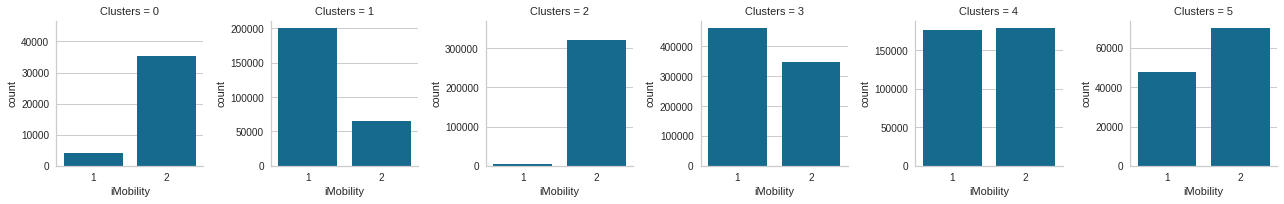

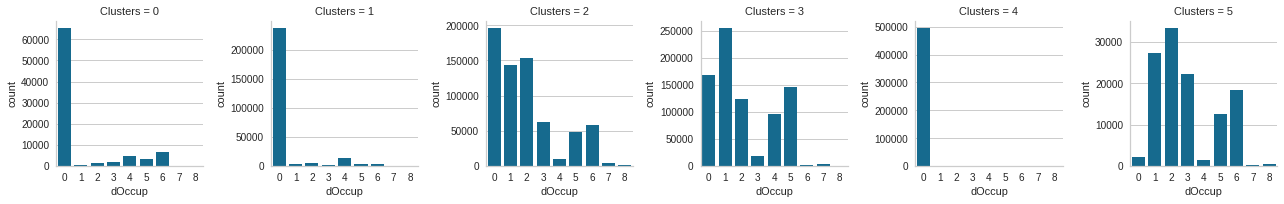

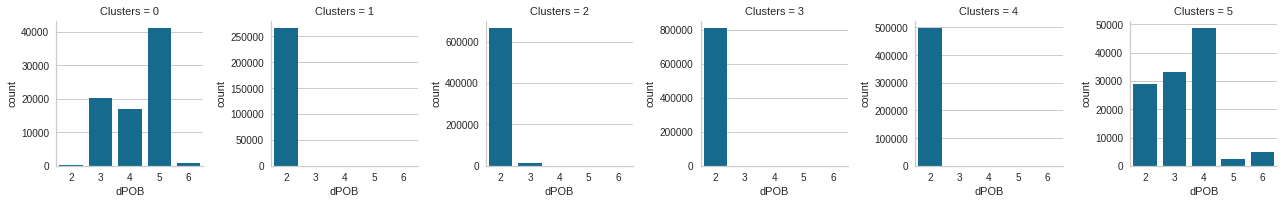

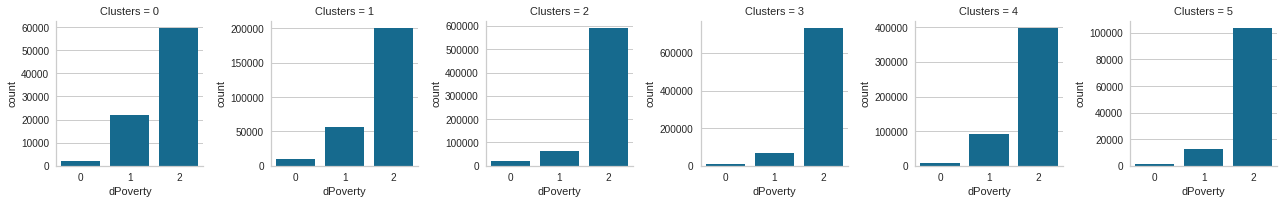

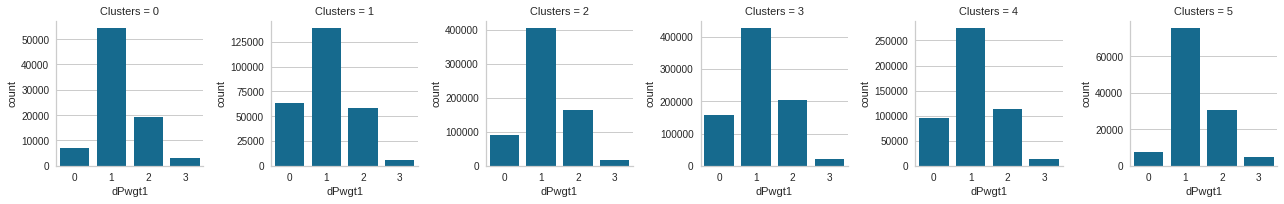

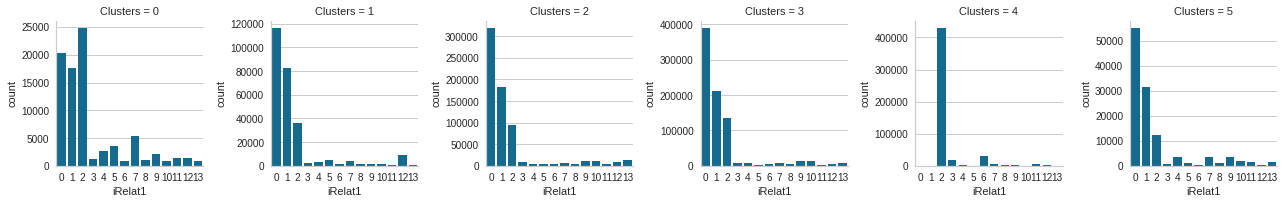

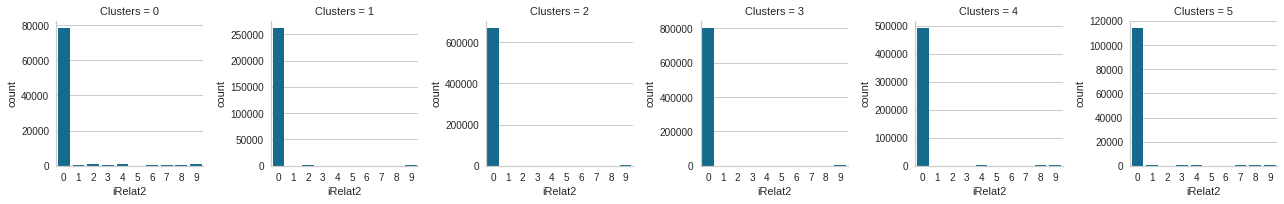

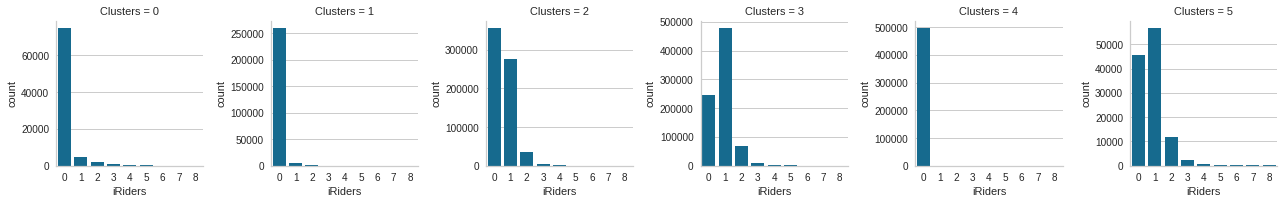

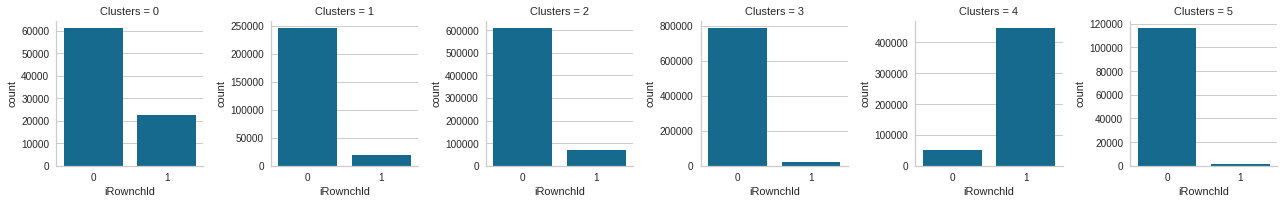

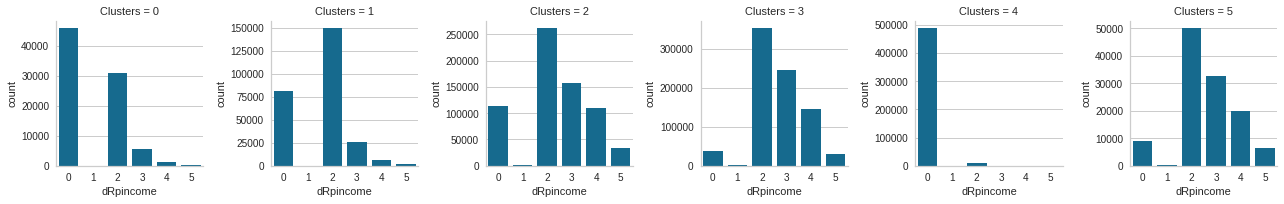

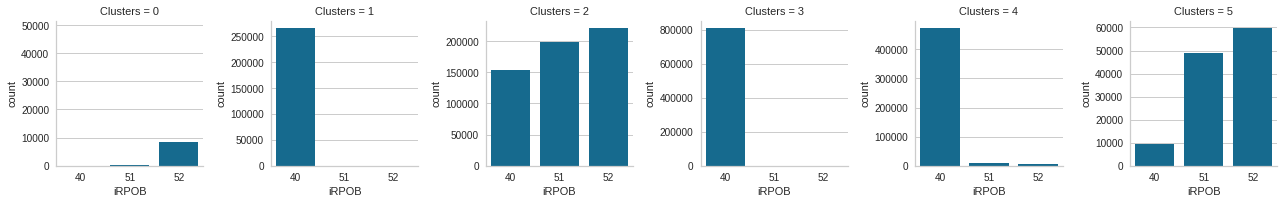

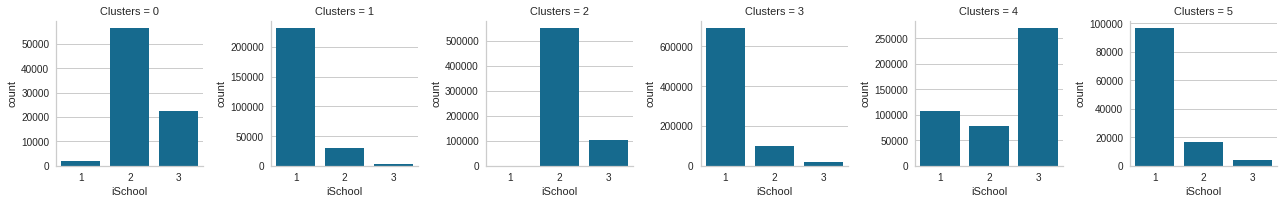

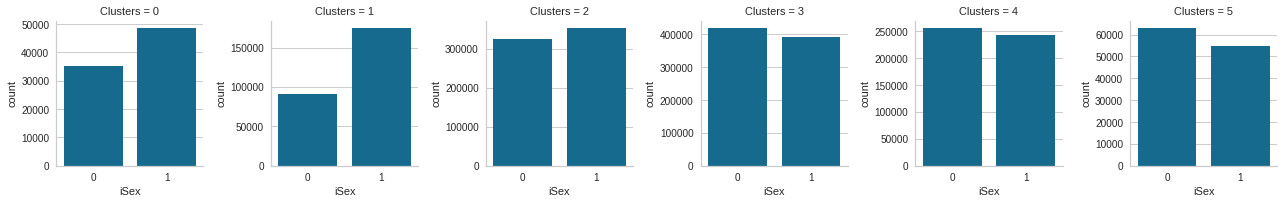

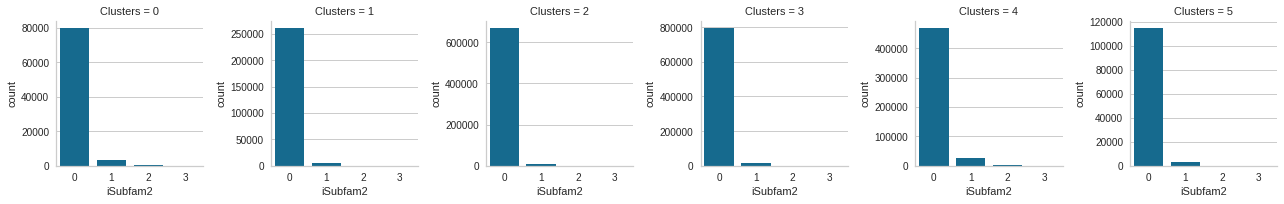

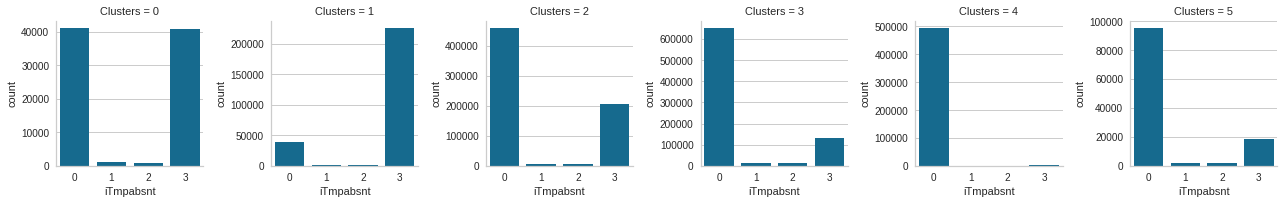

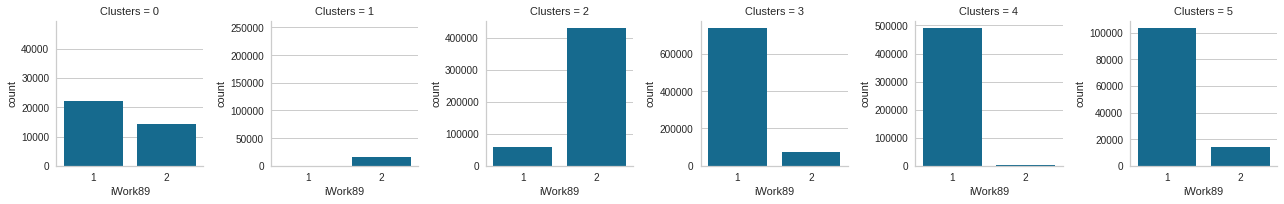

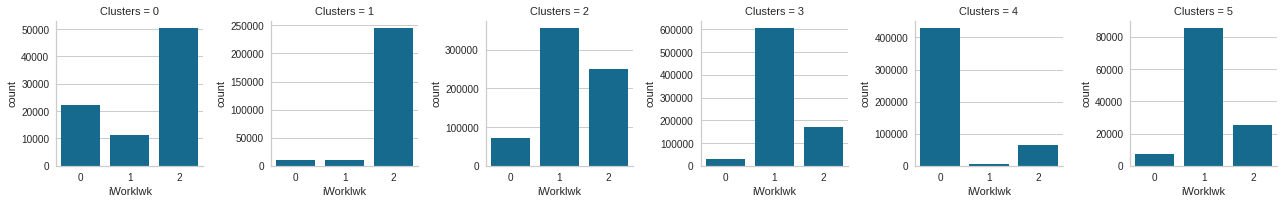

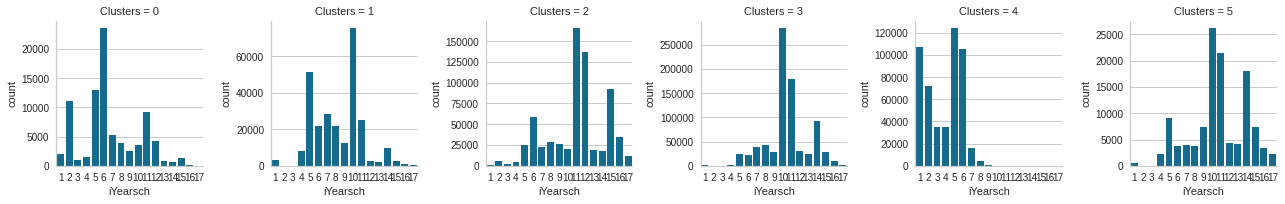

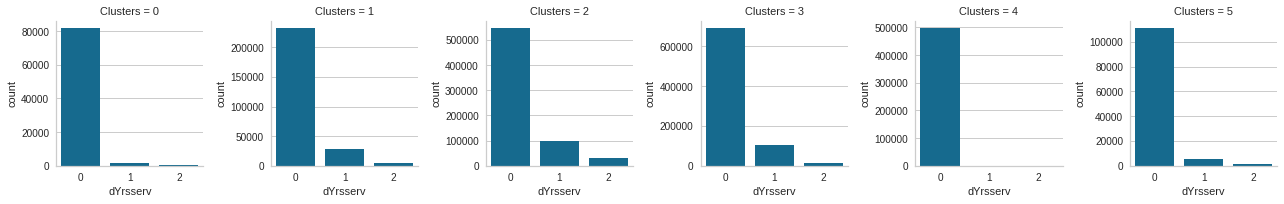

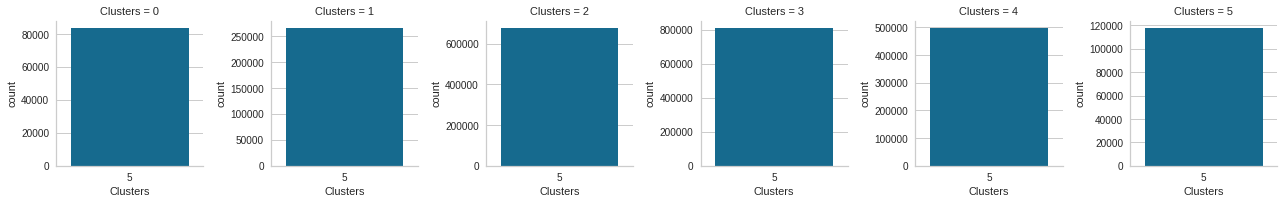

In [ ]:
def get_cluster_overview(df):
  for col in df.columns:
    g = sns.FacetGrid(df,col = "Clusters", sharey = False)
    g.map_dataframe(sns.countplot,x=col)  

get_cluster_overview(df)

Z powyższych wykresów interpretujemy wyniki:

* Grupa 0 - imigranci niepracujący:
  * mniej więcej każdy przedział wiekowy oprócz dzieci
  * wyrózniają się tym że w różnym stopniu posługują się językiem  angielskim i w domu mówią w innym języku niż angielski
  * połowa jest ograniczona ze względu na ilość lub rodzaj pracy (pewnie bariera językowa)
  * całkiem dużo osob z krajów hiszpańskich
  * większość skończyła kształcenie na poziomie 6 klasy podstawówki, lub po highschool
   * jest calkiem duzo z hispanic

* Grupa 1 - żołnierze, weterani, emeryci: (pewnie dobrze by było finalnie rozdzielić emerytów i wojskowych patrząć po zmiennej 'iMilitary')
  * większość już nie pracuje 
  * połowa dostaje social secondary income
  * nie zmienia miejsca zamieszkania
  * jest amerykaninem i mówi tylko po angielsku
  * większość ma dzieci, zwykle 1, 3 albo 4
  * większość nie pracowała w poprzednim roku
  * większość jest w małżeństwie lub była w małżeństwie


* Grupa 2 to studenci:
  * chodzi do collegu, raczej publicznego
  * większość pracowała nie pracowała w poprzednim roku, ale pracuje aktualnie
  * często jeżdzą samochodem, ale raczej sami

* Grupa 3 to przeciętni dorośli:
  * pracują
  * nie są w szkole
  * są amerykaninami
  * są w małżeństwie


* Grupa 4 to uczniowie:
  * poniżej 16 lat
  * nie skończyli szkoły, nie ma nikogo, kto ukończył high school
  * nie dostają pieniędzy jakoś z państwa
  * nie mają potomswa
  * większość uczęszcza do szkoły prywatnej
  * każdy pracował w poprzednim roku, ale raczej nie w poprzednim, ale niewielu pracuje aktualnie (pewnie wakacyjnie)
  * nie jeżdżą samochodem

* Grupa 5 - imigranci pracujący
  * mówią w różnym stopniu po angielsku
  * pracują w różnych miejscach
  * są dobrze wykształceni